##### Install OpenCV

In [ ]:
!pip3 install opencv-python
!pip3 install boto3

##### Import libs needed below

In [2]:
# data processing
import pandas as pd 
# AWS
import boto3 
# OpenCV
import cv2
# file path
import os 
# hash img
import hashlib
# plot img
from matplotlib import pyplot as plt 
# array
import numpy as np 
# progress bar
from tqdm import tqdm 

In [2]:
# Apply progress bar to the DataFrame
tqdm.pandas()

##### Define some commonly used functions

In [5]:
# Plot a image read by opencv
def show_cv2_image(cv_img):
    image_rgb = cv2.cvtColor(cv_img, cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.show()
    
# Plot a image read by local path
def show_image_with_path(image_path):
    show_cv2_image(cv2.imread(image_path))  
    
# Add a column to the DataFrame
def add_column(df, col_name, default_value = np.NaN):
    if col_name not in df.columns:
        df[col_name] = default_value
    return df

# Get the full path of a folder under a specific path
def get_folders_under_path(path):
    return [os.path.join(path, x) for x in os.listdir(path) if os.path.isdir(os.path.join(path, x)) ]

##### Create a configuration file for all the images

In [4]:
# Create a dataframe to store the image info
config = pd.DataFrame(columns=['name', 'hash', 'path'])

# Get all the folders under heads folder
sub_folder = get_folders_under_path('Test')

# Get all the images under each folder
for f in sub_folder:
    names = f.split('/')[-1]
    for img in os.listdir(f):
        if img.endswith('.jpg') or img.endswith('.png'):
            path = os.path.join(f, img)
            config.loc[len(config)] = {'name': names, 'hash': hashlib.md5(open(path, 'rb').read()).hexdigest(), 'path': path}

In [5]:
print(config.info)
config.info()

<bound method DataFrame.info of                 name                              hash   
0    Christina Ricci  466494b76a7535a0706aa84c5f391993  \
1    Christina Ricci  74965b3ca5418852c50a2a445a9754a2   
2    Christina Ricci  e3063cbb222eab24bc53758af8fbb94b   
3    Christina Ricci  24e558c34146f29134f6b253e955e8d7   
4    Christina Ricci  6ed5913de70e530fc6c889a494297725   
..               ...                               ...   
564   Alex Rodriguez  54f45a50d3cd4dcddffee1230cc93fba   
565   Alex Rodriguez  2f5c361e7b7a5eb2522763daf3e3c219   
566   Alex Rodriguez  a66fd9eea7700a0dc9811abbffb67cbe   
567   Alex Rodriguez  083308c3da12eef890540c85c4239ead   
568   Alex Rodriguez  2ea7837b714f6ae4d891a45664ae1583   

                            path  
0    Test/Christina Ricci/63.jpg  
1    Test/Christina Ricci/77.jpg  
2    Test/Christina Ricci/76.jpg  
3    Test/Christina Ricci/62.jpg  
4    Test/Christina Ricci/60.jpg  
..                           ...  
564   Test/Alex Rodriguez/

##### Set up the Amazon Rekognition

In [6]:
from botocore.exceptions import ClientError

# Initialize the Amazon Rekognition client
AWS_ACCESS_KEY_ID ='AKIAQ7GQBF4OUAUP6DLHQ'
AWS_SECRET_ACCESS_KEY ='wIB39vizcgnAyb1T4I1QdiiCdh/dkGp4g6IOCCdoQ'
AWS_REGION = 'us-east-1'
rekognition_client = boto3.client('rekognition', 
                                  region_name=AWS_REGION, 
                                  aws_access_key_id=AWS_ACCESS_KEY_ID, 
                                  aws_secret_access_key=AWS_SECRET_ACCESS_KEY)

def amazon_celebrity_rekognition(cv_imag, rekognition_client = rekognition_client):
    # Convert the image to JPEG format
    _, jpeg_image = cv2.imencode('.jpg', cv_imag)
    jpeg_bytes = jpeg_image.tobytes()
    try:
        # Call the celebrity recognition API
        response = rekognition_client.recognize_celebrities(Image={'Bytes': jpeg_bytes})
    except ClientError as e:
        print('Something went wrong with rekognition: ' + e.to_string())
        return []
    else:
        return response['CelebrityFaces']

##### Feed original images to Amazon rekognition to test the recoginition rate

In [ ]:
original_recog_rate = 'orin_match'
config = add_column(config, original_recog_rate, 0.0)

# Get the original celebrity recognition result
def recognize_original(row):
    image_path = row['path']
    image = cv2.imread(image_path)
    celebrities = amazon_celebrity_rekognition(image)
    if len(celebrities) > 0:
        row[original_recog_rate] = format( celebrities[0]['MatchConfidence'], '.2f')
    return row
# update the original celebrity recognition result to the config dataframe
config = config.progress_apply(recognize_original, axis=1)

In [200]:
config

,name,hash,path,orin_match,gnoise-2.0,gnoise-2.1,gnoise-2.2,gnoise-2.3,gnoise-2.4,gnoise-2.5,gnoise-2.6,gnoise-2.7,gnoise-2.8,gnoise-2.9,gnoise-3.0
0,Christina Ricci,466494b76a7535a0706aa84c5f391993,Test/Christina Ricci/63.jpg,99.80,91.09,80.04,0.0,94.61,0.0,0.0,80.74,0.0,0.0,0.0,0.0
1,Christina Ricci,74965b3ca5418852c50a2a445a9754a2,Test/Christina Ricci/77.jpg,99.59,95.83,0.0,98.04,95.84,80.36,95.81,96.69,98.87,76.84,91.95,95.72
2,Christina Ricci,e3063cbb222eab24bc53758af8fbb94b,Test/Christina Ricci/76.jpg,99.56,78.69,98.75,81.67,93.45,94.90,91.51,92.89,87.16,76.80,0.0,0.0
3,Christina Ricci,24e558c34146f29134f6b253e955e8d7,Test/Christina Ricci/62.jpg,99.66,93.05,81.97,87.77,0.0,0.0,96.73,0.0,76.51,87.27,0.0,93.44
4,Christina Ricci,6ed5913de70e530fc6c889a494297725,Test/Christina Ricci/60.jpg,99.93,95.57,86.34,83.98,92.10,85.28,90.99,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,Alex Rodriguez,54f45a50d3cd4dcddffee1230cc93fba,Test/Alex Rodriguez/44.jpg,92.53,0.0,0.0,75.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
565,Alex Rodriguez,2f5c361e7b7a5eb2522763daf3e3c219,Test/Alex Rodriguez/45.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,76.23
566,Alex Rodriguez,a66fd9eea7700a0dc9811abbffb67cbe,Test/Alex Rodriguez/3.jpg,81.66,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
567,Alex Rodriguez,083308c3da12eef890540c85c4239ead,Test/Alex Rodriguez/1.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [199]:
# Define a function to compute the accuracy
def compute_accuracy(data, column_name, match_threshold = 70):
    c = data[column_name].astype(float)
    c[c >= match_threshold] = 1.0
    return (c.sum() / len(c))

# Plot the accuracy curve based on different confidence thresholds
def plot_accuracy_curve(data, column_name, min_threshold = 70, max_threshold = 100, step = 1):
    confidence_thresholds = np.arange(min_threshold, max_threshold, step)
    accuracies = [compute_accuracy(data, column_name, cft) for cft in confidence_thresholds]
    plt.plot(confidence_thresholds, accuracies)
    plt.xlabel('Threshold')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.ylim(0, 1)
    plt.show()


print(config)
confidence_thresholds = np.arange(70, 100, 1)

print(confidence_thresholds)
accuracies = [compute_accuracy(config, original_recog_rate, cft) for cft in confidence_thresholds]

print(accuracies)
# # Plot the accuracy curve
# plt.plot(confidence_thresholds, accuracies)
# # Set the x-axis label and y-axis label
# plt.xlabel('Threshold')
# plt.ylabel('Accuracy')
# # Set the title of the plot
# plt.title('Accuracy Curve')
# # Set the y-axis limits
# plt.ylim(0, 1)
# # Display the plot
# plt.show()

                name                              hash   
0    Christina Ricci  466494b76a7535a0706aa84c5f391993  \
1    Christina Ricci  74965b3ca5418852c50a2a445a9754a2   
2    Christina Ricci  e3063cbb222eab24bc53758af8fbb94b   
3    Christina Ricci  24e558c34146f29134f6b253e955e8d7   
4    Christina Ricci  6ed5913de70e530fc6c889a494297725   
..               ...                               ...   
564   Alex Rodriguez  54f45a50d3cd4dcddffee1230cc93fba   
565   Alex Rodriguez  2f5c361e7b7a5eb2522763daf3e3c219   
566   Alex Rodriguez  a66fd9eea7700a0dc9811abbffb67cbe   
567   Alex Rodriguez  083308c3da12eef890540c85c4239ead   
568   Alex Rodriguez  2ea7837b714f6ae4d891a45664ae1583   

                            path orin_match gnoise-2.0 gnoise-2.1 gnoise-2.2   
0    Test/Christina Ricci/63.jpg      99.80      91.09      80.04        0.0  \
1    Test/Christina Ricci/77.jpg      99.59      95.83        0.0      98.04   
2    Test/Christina Ricci/76.jpg      99.56      78.69      98.

In [201]:
config.to_csv('config.csv', index=False)

In [3]:
config = pd.read_csv('config.csv')

In [167]:
# Add gaussian noise to image
def gaussian_noise(image, stddev = 0.5):
    noise = np.random.normal(0, stddev,image.shape).astype(np.uint8)
    noisy_image = cv2.add(image, noise)
    return noisy_image

def gaussian_noise_recogize(row, stddev = 0.5):
    # print(stddev)
    image_path = row['path']
    noisy_image = gaussian_noise(cv2.imread(image_path),stddev)
    celebrities = amazon_celebrity_rekognition(noisy_image)
    if len(celebrities) > 0:
        row[column_name] = format(celebrities[0]['MatchConfidence'], '.2f')
    return row

# Define the standard deviation array to apply gaussian noise
stddev_array = np.arange(2.0, 3.0+0.1, 0.1)
for stddev in stddev_array:
    column_name = 'gnoise-' + format(stddev, '.1f')
    # print(column_name)
    add_column(config, column_name, 0.0)
    config = config.progress_apply(gaussian_noise_recogize, axis=1, stddev=stddev)

100%|██████████| 569/569 [03:50<00:00,  2.46it/s]


In [168]:
# config.drop(columns=['original_recog_confidence'], inplace=True)
config

,name,hash,path,orin_match,gnoise-2.0,gnoise-2.1,gnoise-2.2,gnoise-2.3,gnoise-2.4,gnoise-2.5,gnoise-2.6,gnoise-2.7,gnoise-2.8,gnoise-2.9,gnoise-3.0
0,Christina Ricci,466494b76a7535a0706aa84c5f391993,Test/Christina Ricci/63.jpg,99.80,91.09,80.04,0.0,94.61,0.0,0.0,80.74,0.0,0.0,0.0,0.0
1,Christina Ricci,74965b3ca5418852c50a2a445a9754a2,Test/Christina Ricci/77.jpg,99.59,95.83,0.0,98.04,95.84,80.36,95.81,96.69,98.87,76.84,91.95,95.72
2,Christina Ricci,e3063cbb222eab24bc53758af8fbb94b,Test/Christina Ricci/76.jpg,99.56,78.69,98.75,81.67,93.45,94.90,91.51,92.89,87.16,76.80,0.0,0.0
3,Christina Ricci,24e558c34146f29134f6b253e955e8d7,Test/Christina Ricci/62.jpg,99.66,93.05,81.97,87.77,0.0,0.0,96.73,0.0,76.51,87.27,0.0,93.44
4,Christina Ricci,6ed5913de70e530fc6c889a494297725,Test/Christina Ricci/60.jpg,99.93,95.57,86.34,83.98,92.10,85.28,90.99,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,Alex Rodriguez,54f45a50d3cd4dcddffee1230cc93fba,Test/Alex Rodriguez/44.jpg,92.53,0.0,0.0,75.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
565,Alex Rodriguez,2f5c361e7b7a5eb2522763daf3e3c219,Test/Alex Rodriguez/45.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,76.23
566,Alex Rodriguez,a66fd9eea7700a0dc9811abbffb67cbe,Test/Alex Rodriguez/3.jpg,81.66,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
567,Alex Rodriguez,083308c3da12eef890540c85c4239ead,Test/Alex Rodriguez/1.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


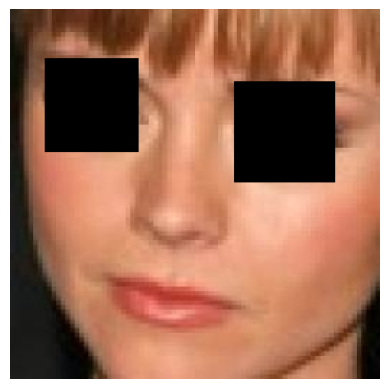

In [9]:
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')
# Iterate over each row in the DataFrame
for index, row in config.iterrows():
    # Read the image path from the current row
    image_path = row['path']
    # Load the image using OpenCV
    image = cv2.imread(image_path)
    eyes = eye_cascade.detectMultiScale(image, scaleFactor=1.1, minNeighbors=5, minSize=(45, 45))
    for (x, y, w, h) in eyes:
        # cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.rectangle(image, (x, y), (x+w, y+h), (0, 0, 0), -1)
    show_cv2_image(image)
    break

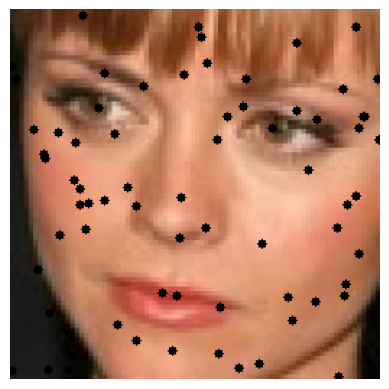

In [20]:
import random
# Define the properties of the spots
spot_radius_range = (3, 3)  # Range of spot radii
spot_color = (0, 0, 0, 2)  # Spot color (BGR format)
num_spots = 70  # Number of spots to draw

for index, row in config.iterrows():
    # Read the image path from the current row
    image_path = row['path']
    # Load the image using OpenCV
    image = cv2.imread(image_path)
    
    # Generate and draw leopard spots
    height, width = image.shape[:2]
    for _ in range(num_spots):
        spot_radius = random.randint(*spot_radius_range)
        spot_center = (random.randint(0, width), random.randint(0, height))
        cv2.circle(image, spot_center, spot_radius, spot_color, -1)
    show_cv2_image(image)
    break

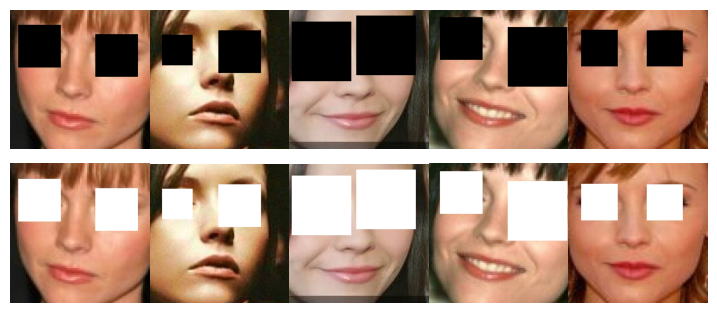

In [113]:
def plot_multiple_images(row, nums_in_row, images, figsize=(9, 4)):
    # Create a figure and subplots with a row of images
    fig, axs = plt.subplots(row, nums_in_row, figsize=figsize)
    # Adjust spacing between subplots
    fig.subplots_adjust(hspace=0, wspace=0)
    if axs.ndim == 1: axs = axs.reshape((1,-1))
    capabilities = row * nums_in_row
    min_one = min(capabilities, len(images))
    for i in range(min_one):
        image = images[i]
        row = i // nums_in_row
        column = i % nums_in_row
        axs[row][column].imshow(image)
        axs[row][column].axis('off')

    # Adjust the spacing between subplots
    # plt.tight_layout()
    plt.show()
    return fig, axs


eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

images = []
# Iterate over each row in the DataFrame
for index, row in config.iterrows():
    # Read the image path from the current row
    image_path = row['path']
    # Load the image using OpenCV
    image = cv2.imread(image_path)
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    eyes = eye_cascade.detectMultiScale(gray, scaleFactor=1.4, minNeighbors=5, minSize=(10, 10))
    for (x, y, w, h) in eyes:
        # cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.rectangle(image, (x, y), (x+w, y+h), (0, 0, 0), -1)
    images.append(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if index >= 4: break


# s = plot_multiple_images(1, 5, images)


# Iterate over each row in the DataFrame
for index, row in config.iterrows():
    # Read the image path from the current row
    image_path = row['path']
    # Load the image using OpenCV
    image = cv2.imread(image_path)
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    eyes = eye_cascade.detectMultiScale(gray, scaleFactor=1.4, minNeighbors=5, minSize=(10, 10))
    for (x, y, w, h) in eyes:
        # cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.rectangle(image, (x, y), (x+w, y+h), (255, 255, 255), -1)
    images.append(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if index >= 4: break


s = plot_multiple_images(2, 5, images)


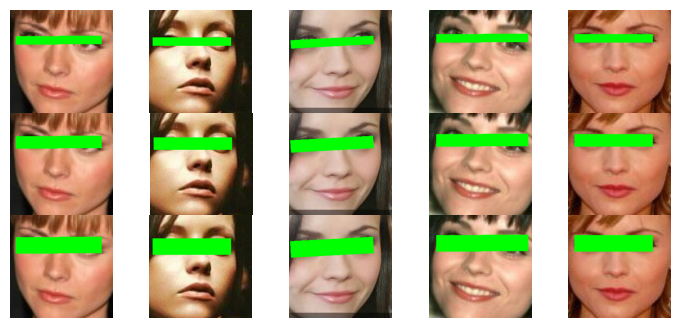

In [114]:
def calculate_angle_of_line(start_point, end_point):
    # Calculate the differences in x and y coordinates
    delta_x = end_point[0] - start_point[0]
    delta_y = end_point[1] - start_point[1]

    # Calculate the angle in radians using arctan2
    angle_rad = np.arctan2(delta_y, delta_x)

    # Convert the angle to degrees
    # angle_deg = np.rad2deg(angle_rad)
    return angle_rad

def draw_rectangle_along_line(image,w, h, ls, le):
    angle = calculate_angle_of_line(ls, le)
    # Define the rotation matrix
    center_x = (ls[0] + le[0]) / 2.0
    center_y = (ls[1] + le[1]) / 2.0
    center_point = (center_x, center_y)
    rotation_matrix = cv2.getRotationMatrix2D(center_point, angle, 1.0)
    
    # Define the corner points of the rectangle
    corners = np.array([[-w/2, -h/2], [w/2, -h/2], [w/2, h/2], [-w/2, h/2]])
    # Rotate the corner points
    rotated_corners = cv2.transform(np.array([corners]), rotation_matrix)[0]
    # Shift the rotated corners to the center position
    rotated_corners[:, 0] += center_x
    rotated_corners[:, 1] += center_y
    # Draw the rotated solid rectangle
    cv2.fillPoly(image, [np.int32(rotated_corners)], (0, 255, 0))



images = []    
# Iterate over each row in the DataFrame
for index, row in config.iterrows():
    # Read the image path from the current row
    image_path = row['path']
    # Load the image using OpenCV
    image = cv2.imread(image_path)
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    eyes = eye_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=3, minSize=(55, 55))

    if len(eyes) < 2: continue
        
    rec1 = (eyes[0][0], eyes[0][1], eyes[0][2], eyes[0][3])
    rec2 = (eyes[1][0], eyes[1][1], eyes[1][2], eyes[1][3])
    
    center_r1 = (rec1[0] + rec1[2] // 2, rec1[1] + rec1[3] // 2)
    center_r2 = (rec2[0] + rec2[2] // 2, rec2[1] + rec2[3] // 2)
    
    distance = np.sqrt((center_r1[0] - center_r2[0])**2 + (center_r1[1] - center_r2[1])**2)
    
    draw_rectangle_along_line(image, distance * 1.6, 20,  center_r1, center_r2)
    
    images.append(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if index >= 4: break
    
    
    
# --------------------------
# Iterate over each row in the DataFrame
for index, row in config.iterrows():
    # Read the image path from the current row
    image_path = row['path']
    # Load the image using OpenCV
    image = cv2.imread(image_path)
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    eyes = eye_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=3, minSize=(55, 55))

    if len(eyes) < 2: continue
        
    rec1 = (eyes[0][0], eyes[0][1], eyes[0][2], eyes[0][3])
    rec2 = (eyes[1][0], eyes[1][1], eyes[1][2], eyes[1][3])
    
    center_r1 = (rec1[0] + rec1[2] // 2, rec1[1] + rec1[3] // 2)
    center_r2 = (rec2[0] + rec2[2] // 2, rec2[1] + rec2[3] // 2)
    
    distance = np.sqrt((center_r1[0] - center_r2[0])**2 + (center_r1[1] - center_r2[1])**2)
    
    draw_rectangle_along_line(image, distance * 1.6, 30,  center_r1, center_r2)
    
    images.append(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if index >= 4: break
    
    
# Iterate over each row in the DataFrame
for index, row in config.iterrows():
    # Read the image path from the current row
    image_path = row['path']
    # Load the image using OpenCV
    image = cv2.imread(image_path)
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    eyes = eye_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=3, minSize=(55, 55))

    if len(eyes) < 2: continue
        
    rec1 = (eyes[0][0], eyes[0][1], eyes[0][2], eyes[0][3])
    rec2 = (eyes[1][0], eyes[1][1], eyes[1][2], eyes[1][3])
    
    center_r1 = (rec1[0] + rec1[2] // 2, rec1[1] + rec1[3] // 2)
    center_r2 = (rec2[0] + rec2[2] // 2, rec2[1] + rec2[3] // 2)
    
    distance = np.sqrt((center_r1[0] - center_r2[0])**2 + (center_r1[1] - center_r2[1])**2)
    
    draw_rectangle_along_line(image, distance * 1.6, 40,  center_r1, center_r2)
    
    images.append(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if index >= 4: break


s = plot_multiple_images(3, 5, images)



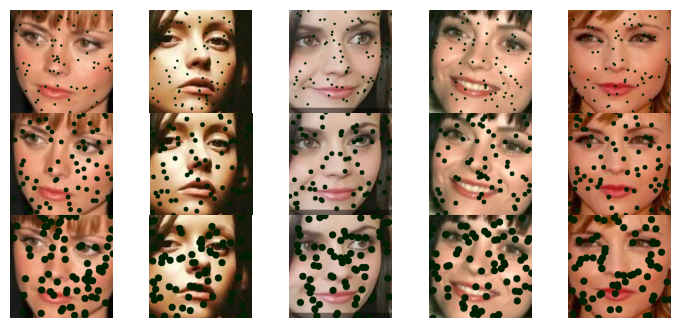

In [129]:
images = []    


# Define the properties of the spots
spot_radius_range = [3, 3]  # Range of spot radii
spot_color = (0, 30, 0, 20)  # Spot color (BGR format)
num_spots = 70  # Number of spots to draw


for i in range(3):
    for index, row in config.iterrows():
        # Read the image path from the current row
        image_path = row['path']
        # Load the image using OpenCV
        image = cv2.imread(image_path)
        
        # Generate and draw leopard spots
        height, width = image.shape[:2]
        for _ in range(num_spots):
            spot_radius_range = (3 + 3 * i, 3 + 3 * i)
            spot_radius = random.randint(*spot_radius_range)
            spot_center = (random.randint(0, width), random.randint(0, height))
            cv2.circle(image, spot_center, spot_radius, spot_color, -1)
        
        images.append(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        if index >= 4: break
    
s = plot_multiple_images(3, 5, images)
